In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from keras import models
from keras import layers
import matplotlib.pyplot as plt

Verover de data. Het is een dataset van IMDB met filmrecensies. De labels zijn binair en geven aan of een film wel of geen aanrader is volgens de reviews.

In [2]:
from keras.datasets import imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=10000,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=42,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

bekijk de geimporteerde data.

In [3]:
X_train[0:10]

array([list([1, 11, 4079, 11, 4, 1986, 745, 3304, 299, 1206, 590, 3029, 1042, 37, 47, 27, 1269, 2, 7637, 19, 6, 3586, 15, 1367, 3196, 17, 1002, 723, 1768, 2887, 757, 46, 4, 232, 1131, 39, 107, 3589, 11, 4, 4539, 198, 24, 4, 1834, 133, 4, 107, 7, 98, 413, 8911, 5835, 11, 35, 781, 8, 169, 4, 2179, 5, 259, 334, 3773, 8, 4, 3497, 10, 10, 17, 16, 3381, 46, 34, 101, 612, 7, 84, 18, 49, 282, 167, 2, 7173, 122, 24, 1414, 8, 177, 4, 392, 531, 19, 259, 15, 934, 40, 507, 39, 2, 260, 77, 8, 162, 5097, 121, 4, 65, 304, 273, 13, 70, 1276, 2, 8, 15, 745, 3304, 5, 27, 322, 2197, 2, 2, 70, 30, 2, 88, 17, 6, 3029, 1042, 29, 100, 30, 4943, 50, 21, 18, 148, 15, 26, 5980, 12, 152, 157, 10, 10, 21, 19, 3196, 46, 50, 5, 4, 1636, 112, 828, 6, 1003, 4, 162, 5097, 2, 517, 6, 2, 7, 4, 9527, 5593, 4, 351, 232, 385, 125, 6, 1693, 39, 2383, 5, 29, 69, 5593, 5670, 6, 162, 5097, 1567, 232, 256, 34, 718, 5612, 2980, 8, 6, 226, 762, 7, 2, 7830, 5, 517, 2, 6, 3242, 7, 4, 351, 232, 37, 9, 1861, 8, 123, 3196, 2, 5612, 188

Zoals je kunt zien bevat `X_train` vectoren met getallen. Elke vector staat voor een review. Elk getal staat voor een woord.

Met onderstaande code kun je een vector met getallen terugvertalen naar woorden. Run deze code.

In [4]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in X_train[0]])
decoded_review

"? in panic in the streets richard widmark plays u s navy doctor who has his week ? interrupted with a corpse that contains plague as cop paul douglas properly points out the guy died from two bullets in the chest that's not the issue here the two of them become unwilling partners in an effort to find the killers and anyone else exposed to the disease br br as was pointed out by any number of people for some reason director ? kazan did not bother to cast the small parts with anyone that sounds like they're from ? having been to new orleans where the story takes place i can personally ? to that richard widmark and his wife barbara ? ? can be ? because as a navy doctor he could be assigned there but for those that are natives it doesn't work br br but with plague out there and the news being kept a secret the new orleans ? starts a ? of the city's underworld the dead guy came off a ship from europe and he had underworld connections a new orleans wise guy played by jack palance jumps to a

In de tekst zie je een aantal vraagtekens. Een vraagteken staat in dit geval voor 'onbekend woord'.

De input is in deze vorm lastig te verwerken voor een neuraal netwerk. De getallen zijn categorische labels. Daarom gebruiken we One-hot-encoding. Helaas kan de `OneHotEncoder` uit sklearn niet overweg met deze input. Daarom maken we de input handmatig geschikt voor het neurale netwerk.

In [5]:
def vectorize_sequences(sequences, dimension=10000):
    # Maak een matrix van de vorm (len(sequences), dimension) met nullen
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # zet de juiste waarden in results[i] op 1
    return results

In [6]:
X_train = vectorize_sequences(X_train)
X_test = vectorize_sequences(X_test)

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

Controleer of het omzetten van de data goed gegaan is

In [7]:
print(X_train.shape)

(25000, 10000)


Maak een neuraal netwerk dat met deze data overweg kan.

In [8]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

# input laag
model.add(Dense(16, input_shape=(10000, ), activation = 'relu'))

# verborgen laag toe
model.add(Dense(16, activation='relu'))

# output laag toe
model.add(Dense(1, activation='sigmoid'))

Kies een loss function en optimizer en compileer het netwerk. Bedenk hierbij goed welke het meest geschikt is voor het probleem dat je aan het oplossen bent en voor de vorm van de output.

In [9]:
# Voor het probleem van binair geclassificeerde recensies, is een veelgebruikte loss function de binary_crossentropy
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                160016    
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


Split in train en validatieset

In [10]:
# Dit helpt bij het controleren van de nauwkeurigheid van het model op ongeziene gegevens en om overpassing te voorkomen.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Train je model model met de gemaakte train- en validatieset. 

In [11]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_test, y_test))

Epoch 1/20
40/40 [==============================] - 3s 29ms/step - loss: 0.4845 - accuracy: 0.7970 - val_loss: 0.3305 - val_accuracy: 0.8762
Epoch 2/20
40/40 [==============================] - 1s 19ms/step - loss: 0.2578 - accuracy: 0.9069 - val_loss: 0.2664 - val_accuracy: 0.8986
Epoch 3/20
40/40 [==============================] - 1s 34ms/step - loss: 0.1911 - accuracy: 0.9355 - val_loss: 0.2582 - val_accuracy: 0.9010
Epoch 4/20
40/40 [==============================] - 1s 33ms/step - loss: 0.1556 - accuracy: 0.9487 - val_loss: 0.2794 - val_accuracy: 0.8898
Epoch 5/20
40/40 [==============================] - 1s 33ms/step - loss: 0.1298 - accuracy: 0.9585 - val_loss: 0.2826 - val_accuracy: 0.8938
Epoch 6/20
40/40 [==============================] - 1s 32ms/step - loss: 0.1066 - accuracy: 0.9689 - val_loss: 0.2965 - val_accuracy: 0.8938
Epoch 7/20
40/40 [==============================] - 1s 33ms/step - loss: 0.0900 - accuracy: 0.9755 - val_loss: 0.3151 - val_accuracy: 0.8882
Epoch 8/20
40

In [14]:
results = model.evaluate(X_test, y_test)
print(results)

157/157 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.8720
[0.6796984672546387, 0.871999979019165]


Plot een learning curve. Zet de accuraatheid uit tegen de epochs en maak onderscheid tussen de training en validatie data. Wat zou volgens dit figuur het optimale aantal epochs zijn?

- Rond 3 epochs

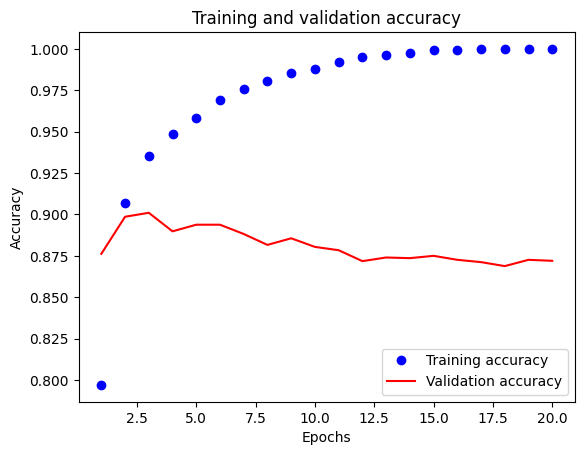

In [20]:
# training geschiedenis opvragen
history_dict = history.history

# De variabelen acc en val_acc bevatten de nauwkeurigheid van het model op de training en validatie set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# De loss en val_loss bevatten de verlieswaarden van het model op de training en validatie set
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Plot een foutcurve. Zet de loss uit tegen de epochs en maak onderscheid tussen de training en validatie data. Bekijk of er misschien sprake is van overfitting/underfitting.

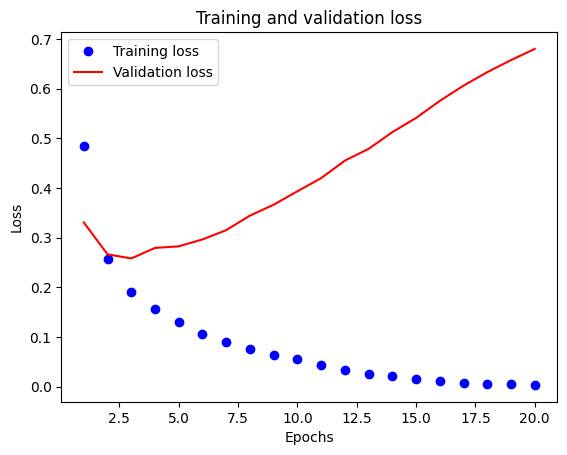

In [19]:
# Maak een plot van de trainings- en validatieverlies tegen de epochs
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Test je model

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

157/157 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.8720
Test loss: 0.6796984672546387
Test accuracy: 0.871999979019165


Kijk wat er gebeurt met de foutcurves van de train en validatiedata en met de testscore als je verschillende netwerken maakt met verschillende instellingen (aantal lagen, aantal neuronen, optimizer).

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

model_2 = Sequential()

# input laag
model_2.add(Dense(64, input_shape=(10000, ), activation = 'tanh'))

# verborgen laag toe
model_2.add(Dense(64, activation='tanh'))

# nog een laag
model_2.add(Dense(64, activation='tanh'))

# output laag toe
model_2.add(Dense(1, activation='sigmoid'))

In [24]:
model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                640064    
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 648,449
Trainable params: 648,449
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model_2.fit(X_train, y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_test, y_test))

Epoch 1/20
40/40 [==============================] - 3s 49ms/step - loss: 0.4459 - accuracy: 0.7895 - val_loss: 0.3700 - val_accuracy: 0.8400
Epoch 2/20
40/40 [==============================] - 1s 34ms/step - loss: 0.2633 - accuracy: 0.8946 - val_loss: 0.2570 - val_accuracy: 0.8984
Epoch 3/20
40/40 [==============================] - 1s 34ms/step - loss: 0.1973 - accuracy: 0.9224 - val_loss: 0.4244 - val_accuracy: 0.8398
Epoch 4/20
40/40 [==============================] - 1s 34ms/step - loss: 0.1766 - accuracy: 0.9316 - val_loss: 0.3020 - val_accuracy: 0.8754
Epoch 5/20
40/40 [==============================] - 1s 34ms/step - loss: 0.1501 - accuracy: 0.9446 - val_loss: 0.2842 - val_accuracy: 0.8942
Epoch 6/20
40/40 [==============================] - 1s 34ms/step - loss: 0.1278 - accuracy: 0.9542 - val_loss: 0.3311 - val_accuracy: 0.8914
Epoch 7/20
40/40 [==============================] - 1s 35ms/step - loss: 0.1134 - accuracy: 0.9591 - val_loss: 0.3506 - val_accuracy: 0.8836
Epoch 8/20
40

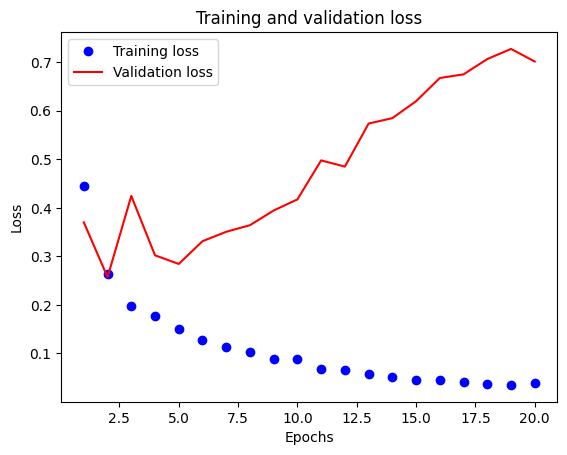

In [26]:
# Maak een plot van de trainings- en validatieverlies tegen de epochs
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Bonusvraag: Zoek uit wat dropout lagen voor deep learning zijn en experimenteer met dropout lagen in jouw netwerk. Welke effect heeft dit op de resultaten?